In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


# carregar arquivo .mat
mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction']
out_data_ext = mat['out_extraction']
in_data_val = mat['in_validation']
out_data_val = mat['out_validation']


lista = [in_data_ext, out_data_ext, in_data_val, out_data_val]

modulos = []
for i in lista:
    modulos.append(max(i.imag))
    modulos.append(max(i.real))

maior_modulo = max(modulos)

in_ext_norm   = in_data_ext/maior_modulo
out_ext_norm  = out_data_ext/maior_modulo
in_val_norm   = in_data_val/maior_modulo
out_val_norm = out_data_val/maior_modulo

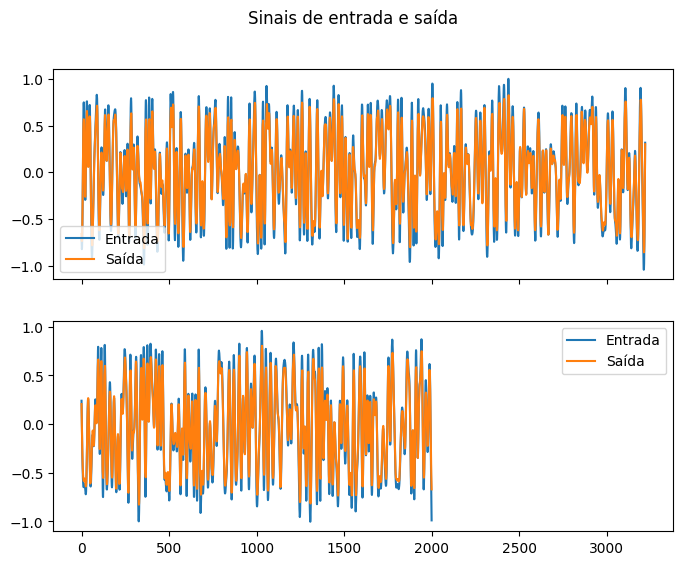

In [2]:
# plotar sinais de entrada e saída
x_ext = range(len(in_data_ext))
x_val = range(len(in_data_val))

fig, axs = plt.subplots(2, sharex=True, figsize=(8, 6))
fig.suptitle('Sinais de entrada e saída')
axs[0].plot(x_ext, np.real(in_ext_norm), label='Entrada')
axs[0].plot(x_ext, np.real(out_ext_norm), label='Saída')
axs[0].legend()
axs[1].plot(x_val, np.real(in_val_norm), label='Entrada')
axs[1].plot(x_val, np.real(out_val_norm), label='Saída')
axs[1].legend()
plt.show()

In [3]:
def mp(P, M, xn):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                XX[l-M-1, ((p-1)*(M+1))+m] = (np.abs(xn[l-m]**(2*p-2))*(xn[l-m]))[0]
    return XX

def readeq(val, precision):
    return int(np.floor(val / (2 ** precision)))

def mp_int(P, M, xn, precision):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                real_part = np.real(xn[l-m])[0].astype(np.int64)
                imag_part = np.imag(xn[l-m])[0].astype(np.int64)
                for _ in range(2,(2*p-2)):
                    real_part = readeq(real_part*real_part, precision)
                    imag_part = readeq(imag_part*imag_part, precision)
                     
                # modulo_square = readeq(modulo_square*modulo_square, precision)
                modulo_square = readeq(real_part ** 2 + imag_part ** 2, precision)

                real_part = readeq(real_part * modulo_square, precision)
                imag_part = readeq(imag_part * modulo_square, precision)


                XX[l-M-1, ((p-1)*(M+1))+m] = complex(real_part,imag_part) 
    return XX

def MultiplicadorMatrizes(coefficients, XX, precision):
    max_value = 0  # Variável para acompanhar o maior valor encontrado durante o processo

    # Realizar a multiplicação elemento por elemento e aplicar as conversões
    result = np.zeros_like(XX, dtype=np.complex128)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
                
            # Readequar o resultado (divisão e arredondamento para baixo)
            produto = coefficients[j,0] * XX[i, j]
            readequated_real = readeq(np.real(produto).astype(np.int64), precision)
            readequated_imag = readeq(np.imag(produto).astype(np.int64), precision)

            # Atualizar o máximo valor encontrado
            max_value = max(max_value, readequated_real)
            max_value = max(max_value, readequated_imag)
            
            # Converter de volta para decimal
            result[i, j] = complex(readequated_real, readequated_imag) 

    soma_filas = np.sum(result, axis=1).reshape(-1, 1)

    # Calcular a quantidade de bits extras para evitar overflow
    extra_bits = np.ceil(np.log2(max_value + 1))
    
    return soma_filas, extra_bits



In [10]:
bits_precisao = [2, 4, 6, 8, 10, 15, 20, 25]  # Exemplo de quantidade de bits para a precisão
bits_precisao = [15]
nmse_values = []

P = 5
M = 1

XX_ext_norm = mp(P, M, in_ext_norm)
coefficients, _, _, _ = np.linalg.lstsq(XX_ext_norm, out_ext_norm[M:], rcond=None)

for p_bits in bits_precisao:
    # Converter para vírgula fixa
    in_val_fixed = np.round(in_val_norm * 2 ** p_bits) 
    out_val_fixed = np.round(out_val_norm * 2 ** p_bits) 
    coefficients_norm = np.round(coefficients * 2 ** p_bits)
    
    #XX_val = mp_int(P, M, in_val_fixed, p_bits)
    XX_val = mp(P, M, in_val_norm)
    XX_val = np.round(XX_val * 2 ** p_bits) 

    # Calcular o NMSE
    predicted_val_fixed, e_bits = MultiplicadorMatrizes(coefficients_norm, XX_val, p_bits)
    nmse_fixed = 10 * np.log10(np.mean(np.abs(out_val_fixed[M:] - predicted_val_fixed) ** 2) / np.mean(np.abs(out_val_fixed[M:]) ** 2))

    # Levar em consideração os bits extras para evitar overflow
    total_bits = p_bits + 1 + e_bits
    nmse_values.append((p_bits, total_bits, nmse_fixed))


for p_bits, total_bits, nmse in nmse_values:
    print(f"Bits de precisão: {p_bits}\t,Bits total: {total_bits}\t, NMSE: {nmse} dB")

Bits de precisão: 15	,Bits total: 33.0	, NMSE: -23.743214908934913 dB


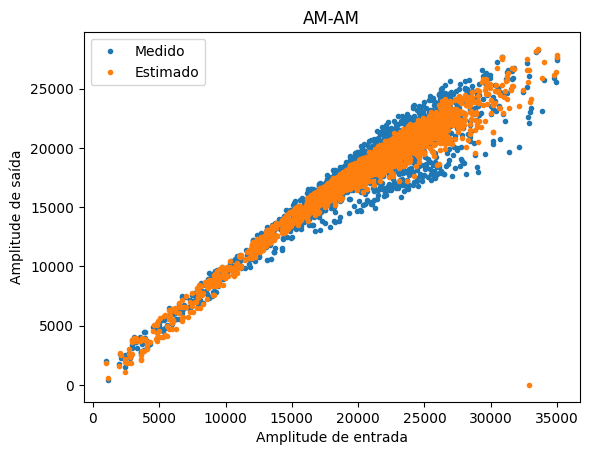

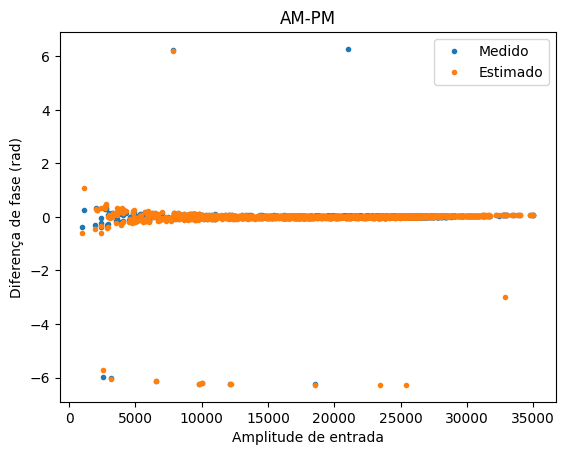

In [11]:
# Gráficos AM-AM e AM-PM
plt.figure()
plt.plot(np.abs(in_val_fixed[M:]), np.abs(out_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_val_fixed[M:]), np.abs(predicted_val_fixed), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.figure()
plt.plot(np.abs(in_val_fixed[M:]), np.angle(out_val_fixed[M:])-np.angle(in_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_val_fixed[M:]), np.angle(predicted_val_fixed)-np.angle(in_val_fixed[M:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Diferença de fase (rad)')
plt.title('AM-PM')
plt.legend()